### Load dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


## Emulation of CMIP6 models
Here we perform the emulation of individual CMIP6 models based on our tuned carbon cycle, response, and aerosol forcing parameters.

In [2]:
## read in the response parameter values:

response_params = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

ERFari_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFari.csv',index_col=0)

### LOG so2 ERFaci params
ERFaci_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFaci.csv',index_col=0)

fair_default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',index_col=0,skiprows=1)

cc_params = pd.read_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_240820_byOLSE_plus_rA.csv',index_col=0)

In [3]:
## convert the response params to FaIR params

def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    return pd.DataFrame([tau,q],index=['d','q'],columns=[1,2,3])

In [4]:
def forc_vals_to_f(F_2x,F_4x,PI_conc=284):
    
    f3 = (2*F_2x - F_4x) / (2 * np.sqrt(PI_conc*2) - np.sqrt(PI_conc*4) - np.sqrt(PI_conc) )
    f1 = (F_2x - f3 * (np.sqrt(PI_conc*2) - np.sqrt(PI_conc))) / np.log(2)
    return np.array([f1,f3])

response_params.loc['ECS'] = np.nan
response_params.loc['TCR'] = np.nan
for model in response_params.columns:
    fair_params = pd.concat([convert_geoffrey_to_FaIR(response_params.loc[:'F_4x',model].values)],axis=1,keys=[model])
    response_params.loc[['ECS','TCR'],model] = q_to_tcr_ecs(fair_params,F_2x = response_params.loc['F_2x',model]).iloc[:,0]
response_params.loc['RWF'] = response_params.loc['TCR'] / response_params.loc['ECS']

In [5]:
## get cmip6 response parameters:

fair_param_df = pd.concat([convert_geoffrey_to_FaIR(x.iloc[:10]) for y,x in response_params.iteritems()],axis=1,keys=response_params.columns)

cmip6_gas_params = pd.concat([fair_default_params]*fair_param_df.columns.levels[0].size,axis=1,keys=fair_param_df.columns.levels[0])

C4MIP_data_1=pd.read_csv('../tmp/C4MIP_tas_CO2_flux.csv',index_col=0,header=[0,1,2])

for model in cmip6_gas_params.columns.levels[0]:
    
    if model in cc_params.index:
        cmip6_gas_params.loc[['r0','rC','rT','rA'],(model,'carbon_dioxide')] = cc_params.loc[model,['r0','rC','rT','rA']]
        cmip6_gas_params.loc['PI_conc',(model,'carbon_dioxide')] = C4MIP_data_1[model]['1pctCO2']['CO2'].values[0]/1.01
    else:
        cmip6_gas_params.loc[['r0','rC','rT','rA'],(model,'carbon_dioxide')] = cc_params.loc[:,['r0','rC','rT','rA']].mean()
        cmip6_gas_params.loc['PI_conc',(model,'carbon_dioxide')] = np.mean(C4MIP_data_1.loc[:,(slice(None),'1pctCO2','CO2')].values[0])/1.01
        
    cmip6_gas_params.loc[['f1','f3'],(model,'carbon_dioxide')] = forc_vals_to_f(response_params.loc['F_2x',model],response_params.loc['F_4x',model],PI_conc=cmip6_gas_params.loc['PI_conc',(model,'carbon_dioxide')])
    
    if model in ERFari_params.index:
        cmip6_gas_params.loc['f2',(model,'so2')] = ERFari_params.loc[model,'so2']
        cmip6_gas_params.loc['f2',(model,'bc')] = ERFari_params.loc[model,'bc']
        cmip6_gas_params.loc['f2',(model,'oc')] = ERFari_params.loc[model,'oc']
        cmip6_gas_params.loc['f1',(model,'so2|aci')] = ERFaci_params.loc[model,'beta']
        cmip6_gas_params.loc['PI_conc',(model,'so2')] = ERFaci_params.loc[model,'s']
        cmip6_gas_params.loc['f2',(model,['bc|aci','oc|aci'])] = ERFaci_params.loc[model,'alpha']

## Idealised scenario emulation

In [6]:
## import actual data:

## import the actual data:
abrupt_CMIP6_data = pd.read_csv('../tools/cmip6_data/abrupt4x_tas_N_bias_corr.csv',index_col=0,header=[0,1]).xs('tas',axis=1,level=-1)
onepct_CMIP6_data = pd.read_csv('../tools/cmip6_data/onepct_tas_bias_corr.csv',index_col=0,header=[0,1]).groupby(level=0,axis=1).mean()

In [7]:
## Plots of the abrupt-4x and 1pct emulations:

## get a dataframe of CO2 parameter sets:

onepct_concs = pd.DataFrame(index=np.arange(1850,2850),columns=pd.MultiIndex.from_product([cmip6_gas_params.columns.levels[0],['carbon_dioxide']]))
abrupt4x_concs = pd.DataFrame(index=np.arange(1850,2850),columns=pd.MultiIndex.from_product([cmip6_gas_params.columns.levels[0],['carbon_dioxide']]))

for model in cmip6_gas_params.columns.levels[0]:
    
    if model in C4MIP_data_1.columns:
        onepct_concs.loc[:1850+C4MIP_data_1[model]['1pctCO2']['CO2'].dropna().values.size-1,(model,'carbon_dioxide')] = C4MIP_data_1[model]['1pctCO2']['CO2'].dropna().values
        onepct_concs.loc[1850+C4MIP_data_1[model]['1pctCO2']['CO2'].dropna().values.size-1:,(model,'carbon_dioxide')] = C4MIP_data_1[model]['1pctCO2']['CO2'].dropna().values[-1]*1.01**np.arange(1001-C4MIP_data_1[model]['1pctCO2']['CO2'].dropna().values.size)
    else:
        onepct_concs.loc[:,(model,'carbon_dioxide')] = cmip6_gas_params.loc['PI_conc',(model,'carbon_dioxide')] * 1.01**np.arange(1,1001)
    abrupt4x_concs.loc[:,(model,'carbon_dioxide')] = cmip6_gas_params.loc['PI_conc',(model,'carbon_dioxide')] * 4
    
onepct_concs.loc[1849] = onepct_concs.loc[1850]/1.01
onepct_concs.sort_index(inplace=True)

In [8]:
## run the model

onepct_emulation = run_GIR(concentrations_in=onepct_concs,gas_parameters=cmip6_gas_params.reindex(['carbon_dioxide'],axis=1,level=-1),thermal_parameters=fair_param_df)
abrupt4x_emulation = run_GIR(concentrations_in=abrupt4x_concs,gas_parameters=cmip6_gas_params.reindex(['carbon_dioxide'],axis=1,level=-1),thermal_parameters=fair_param_df)

Integrating 40 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1849 and 2849...


  0%|          | 0/1000 [00:00<?, ? timestep/s]../GIR.py:260: RuntimeWarning: divide by zero encountered in true_divide
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:261: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
../GIR.py:260: RuntimeWarning: invalid value encountered in multiply
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
100%|██████████| 1000/1000 [00:00<00:00, 5444.74 timestep/s]


Integrating 40 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1850 and 2849...


100%|██████████| 999/999 [00:00<00:00, 5894.80 timestep/s]


#### Response simulations

[None, None, None]

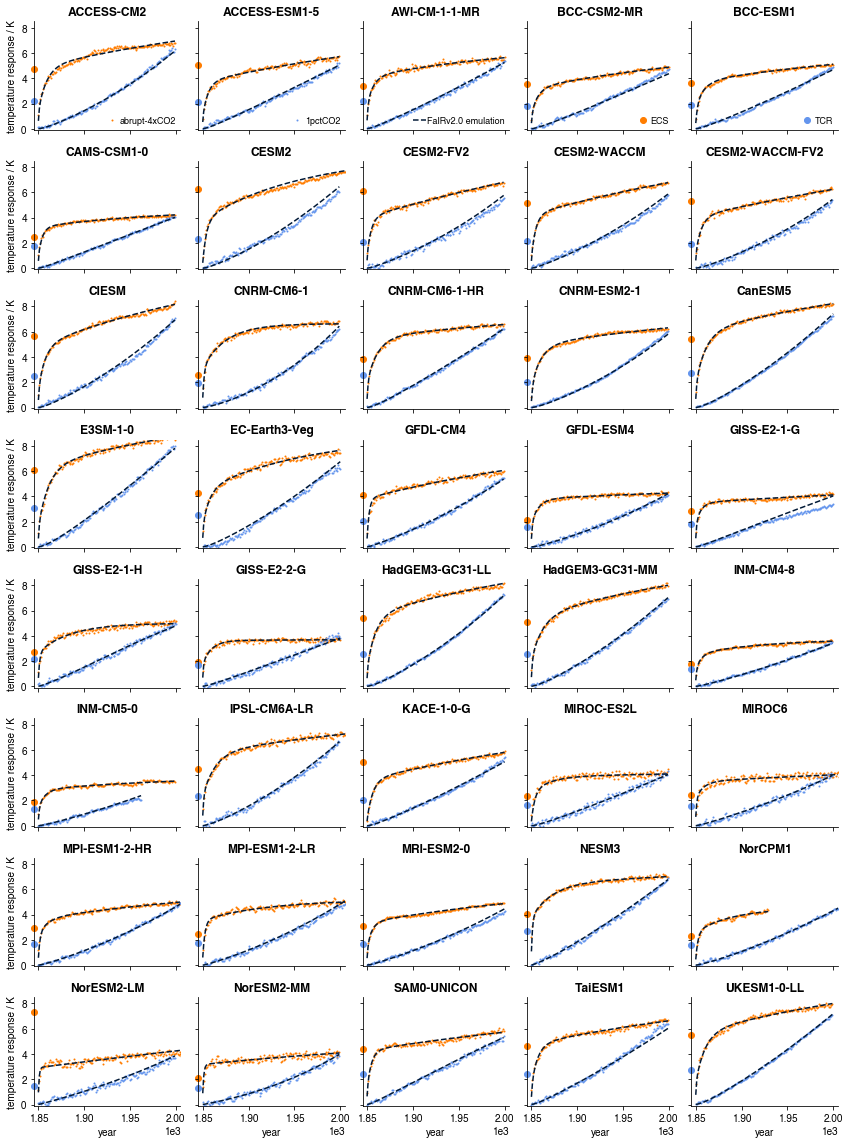

In [10]:
## create a figure

fig,ax = plt.subplots(8,5,figsize=(12,16))

emulation_color = '#011936'
CMIP_color = '#FF7D00'

for i,model in enumerate(abrupt_CMIP6_data.columns):    
    
    abrupt_plot_data = abrupt_CMIP6_data.loc[:,model].dropna().values
    ax.flatten()[i].plot(np.arange(1850,1850+abrupt_plot_data.size),abrupt_plot_data,'o',ms=1,c=CMIP_color)
    onepct_plot_data = onepct_CMIP6_data.loc[:,model].dropna().values
    ax.flatten()[i].plot(np.arange(1850,1850+onepct_plot_data.size),onepct_plot_data,'o',ms=1,c='cornflowerblue')
    
    # onepct starts one year earlier so shift forward by one year
    ax.flatten()[i].plot(np.arange(1850,1850+onepct_plot_data.size),onepct_emulation['T'].loc[:,[model]].values[1:onepct_plot_data.size+1],ls='--',c=emulation_color)
    ax.flatten()[i].plot(np.arange(1850,1850+abrupt_plot_data.size),abrupt4x_emulation['T'].loc[:,[model]].values[:abrupt_plot_data.size],ls='--',c=emulation_color)
    
    line=ax.flatten()[i].plot(1845,response_params.loc['ECS',model],'o',c=CMIP_color,zorder=-10)[0]
    line.set_clip_on(False)
    line=ax.flatten()[i].plot(1845,response_params.loc['TCR',model],'o',c='cornflowerblue',zorder=-10)[0]
    line.set_clip_on(False)
    
    ax.flatten()[i].set_title(model,fontweight='bold')
    
    [ax.flatten()[i].spines[pos].set_visible(False) for pos in ['top','right']]

[a.set_xlim(1845,2005) for a in ax.flatten()]
[a.set_ylim(-0.1,8.5) for a in ax.flatten()]
[a.tick_params(labelbottom=False) for a in ax[:-1].flatten()]
[a.tick_params(labelleft=False) for a in ax[:,1:].flatten()]
[a.set_xlabel('year') for a in ax[-1].flatten()]
[a.set_ylabel('temperature response / K') for a in ax[:,0].flatten()]

# fig.suptitle('abrupt4x-CO2 & 1pctCO2 response emulation',fontweight='bold',y=1.01)
    
ax[0,0].plot([],[],'o',color=CMIP_color,ms=1,label='abrupt-4xCO2')
ax[0,1].plot([],[],'o',color='cornflowerblue',ms=1,label='1pctCO2')
ax[0,2].plot([],[],ls='--',color=emulation_color,lw=1.5,label='FaIRv2.0 emulation')
ax[0,3].plot([],[],'o',color=CMIP_color,label='ECS')
ax[0,4].plot([],[],'o',color='cornflowerblue',label='TCR')
ax[0,0].legend(loc='lower right',prop={'size': 9},labelspacing=0,borderpad=0,handlelength=1.5,handletextpad=0.1)
ax[0,1].legend(loc='lower right',prop={'size': 9},labelspacing=0,borderpad=0,handlelength=1.5,handletextpad=0.1)
ax[0,2].legend(loc='lower right',prop={'size': 9},labelspacing=0,borderpad=0,handlelength=1.5,handletextpad=0.1)
ax[0,3].legend(loc='lower right',prop={'size': 9},labelspacing=0,borderpad=0,handlelength=1.5,handletextpad=0.1)
ax[0,4].legend(loc='lower right',prop={'size': 9},labelspacing=0,borderpad=0,handlelength=1.5,handletextpad=0.1)
    
plt.tight_layout()

# fig.patch.set_facecolor('white')
[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/CMIP6_response_emulation_grid.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

#### Carbon cycle emulations

In [ ]:
cmip6_gas_params_bgc  = cmip6_gas_params.copy().reindex(C4MIP_data_1.columns.levels[0],axis=1,level=0)
cmip6_gas_params_bgc.loc['rT',(slice(None),'carbon_dioxide')] = 0

onepct_bgc_emulation = run_GIR(concentrations_in=onepct_concs.reindex(C4MIP_data_1.columns.levels[0],axis=1,level=0),gas_parameters=cmip6_gas_params_bgc.reindex(['carbon_dioxide'],axis=1,level=-1),thermal_parameters=fair_param_df.reindex(C4MIP_data_1.columns.levels[0],axis=1,level=0))

def calculate_uptake_from_output(output):
    cum_emms = output['Emissions'].rolling(2).mean().replace(np.nan,0).cumsum()
    burden = ((output['C']-output['C'].iloc[0])/4.688876e-01)
    return cum_emms - burden.values

def calculate_airbornefraction_from_output(output):
    emms = output['Emissions'].rolling(2).mean().replace(np.nan,1e-6)
    burden = ((output['C']-output['C'].iloc[0])/4.688876e-01)
    return burden.values / emms.cumsum()

bgc_uptake = calculate_uptake_from_output(onepct_bgc_emulation)
cou_uptake = calculate_uptake_from_output(onepct_emulation)

[None, None, None]

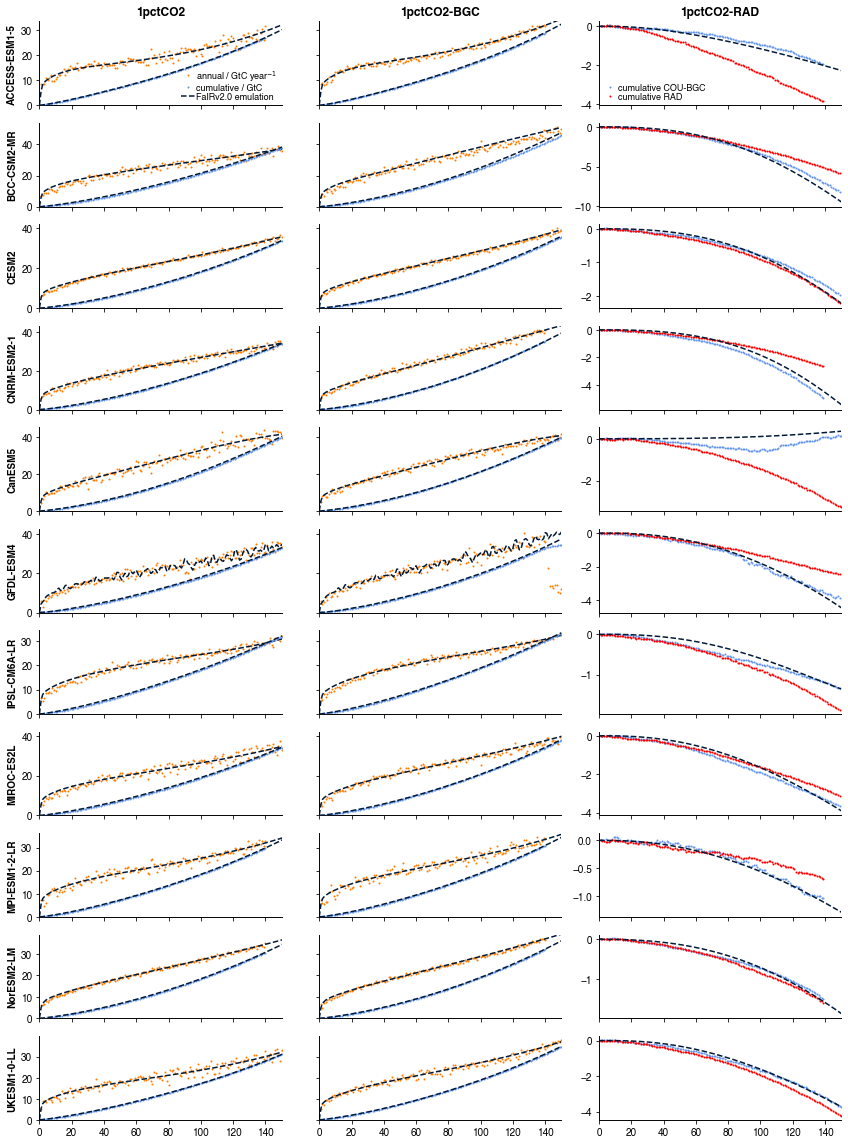

In [146]:
fig,ax = plt.subplots(11,3,figsize=(12,16))

for i,model in enumerate(C4MIP_data_1.columns.levels[0]):
    
    ax1 = [a.twinx() for a in ax[i]]
    
    atms_burden = pd.concat([(C4MIP_data_1.loc[:150,(model,'1pctCO2'+x,'CO2')].dropna()-C4MIP_data_1.loc[:150,(model,'1pctCO2','CO2')].dropna().iloc[0]/1.01)/4.688876e-01 for x in ['','-bgc','-rad']],axis=1)
    cum_emms = pd.concat([C4MIP_data_1.loc[:150,(model,'1pctCO2'+x,'flux')].dropna().cumsum() for x in ['','-bgc','-rad']],axis=1) + atms_burden.values
    
    ax[i,0].plot(np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2','flux')]))),'o',color=CMIP_color,ms=1)
    ax[i,0].plot(np.concatenate(([0],onepct_emulation['Emissions'].loc[:2000,[model]].rolling(2).mean().values[1:,0])),ls='--',color=emulation_color,lw=1.5)
    
    ax1[0].plot(np.concatenate(([0],cum_emms.loc[:,(model,'1pctCO2','flux')])),'o',color='cornflowerblue',ms=1)
    ax1[0].plot(np.concatenate(([0],onepct_emulation['Emissions'].loc[:2000,[model]].rolling(2).mean().values[1:,0])).cumsum(),ls='--',color=emulation_color,lw=1.5)
    
    ax[i,1].plot(np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')]))),'o',color=CMIP_color,ms=1)
    ax[i,1].plot(np.concatenate(([0],onepct_bgc_emulation['Emissions'].loc[:2000,[model]].rolling(2).mean().values[1:,0])),ls='--',color=emulation_color,lw=1.5)
    
    ax1[1].plot(np.concatenate(([0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')])),'o',color='cornflowerblue',ms=1)
    ax1[1].plot(np.concatenate(([0],onepct_bgc_emulation['Emissions'].loc[:2000,[model]].rolling(2).mean().values[1:,0])).cumsum(),ls='--',color=emulation_color,lw=1.5)
    
    ax[i,2].plot((C4MIP_data_1.loc[:,(model,'1pctCO2','flux')].cumsum()-C4MIP_data_1.loc[:,(model,'1pctCO2-bgc','flux')].cumsum())/100,'o',color='cornflowerblue',ms=1)
    ax[i,2].plot(C4MIP_data_1.loc[:,(model,'1pctCO2-rad','flux')].cumsum()/100,'o',color='red',ms=1)
    ax[i,2].plot((cou_uptake.loc[:2000,(model,'carbon_dioxide')]-bgc_uptake.loc[:2000,(model,'carbon_dioxide')]).values/100,ls='--',color=emulation_color,lw=1.5)
    
    [a.spines[pos].set_visible(False) for pos in ['top','right'] for a in ax1]
    [a.tick_params(labelright=False,right=False) for a in ax1]
    
    ax[i,0].set_ylim(0,np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')].dropna()))).max()*1.05)
    ax1[0].set_ylim(0,np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')].dropna()))).max()*100*1.05)
    
    ax[i,1].set_ylim(0,np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')].dropna()))).max()*1.05)
    ax1[1].set_ylim(0,np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')].dropna()))).max()*100*1.05)
    
#     ax[i,1].set_ylim(0,np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')]))).max()*1.05)
#     ax1[1].set_ylim(0,np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')]))).max()*100*1.05)
    
    ax[i,0].set_ylabel(model,fontweight='bold')
    
[a.spines[pos].set_visible(False) for pos in ['top','right'] for a in ax.flatten()]
    
[a.set_xlim(0,150) for a in ax.flatten()]
[ax[0,i].set_title(x,fontweight='bold') for i,x in enumerate(['1pctCO2','1pctCO2-BGC','1pctCO2-RAD'])]
[a.tick_params(labelbottom=False) for a in ax[:-1].flatten()]
[a.tick_params(labelleft=False) for a in ax[:,1].flatten()]

ax[0,0].plot([],[],'o',color=CMIP_color,ms=1,label='annual / GtC year$^{-1}$')
ax[0,0].plot([],[],'o',color='cornflowerblue',ms=1,label='cumulative / GtC')
ax[0,0].plot([],[],ls='--',color=emulation_color,lw=1.5,label='FaIRv2.0 emulation')
ax[0,0].legend(loc='lower right',prop={'size': 9},labelspacing=0,borderpad=0,handlelength=1.5,handletextpad=0.1)

ax[0,-1].plot([],[],'o',color='cornflowerblue',ms=1,label='cumulative COU-BGC')
ax[0,-1].plot([],[],'o',color='red',ms=1,label='cumulative RAD')
ax[0,-1].legend(loc='lower left',prop={'size': 9},labelspacing=0,borderpad=0,handlelength=1.5,handletextpad=0.1)

plt.tight_layout()

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/CMIP6_1pctCO2_cc_emulation_grid.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Aerosol emulation figure

In [85]:
RCMIP_aer_emms = RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur']),'1750':'2100'].droplevel((0,1)).interpolate(axis=1).T.apply(pd.to_numeric)
RCMIP_aer_emms.columns=['bc','oc','so2']
RCMIP_aer_emms-=RCMIP_aer_emms.loc['1750']
CMIP6_aer_forc_zip = ZipFile('/home/leachl/Documents/Simple_models/FaIR_v2-0/GIR/tmp/aer_forc_CMIP6.zip')
CMIP6_aer_forc_fnames = [x.filename for x in CMIP6_aer_forc_zip.infolist()]
CMIP6_aer_forc = pd.concat([pd.read_csv(CMIP6_aer_forc_zip.open(x),index_col=0) for x in CMIP6_aer_forc_fnames],axis=1,keys=[x.split('.')[0] for x in CMIP6_aer_forc_fnames])

In [38]:
# first generate an ensemble to compare to the RFMIP ensemble:

## get coefficients from FULL and CONSTRAINED:

def return_ERFaer_coefs(gas_param_file,response_param_file,level_constraint_file,rate_constrain_file,constrain=False):
    level_constraint = pd.read_pickle(level_constraint_file)
    rate_constraint = pd.read_pickle(rate_constrain_file)
    full_constraint = level_constraint & rate_constraint
    NROY_mems = full_constraint.index.levels[0][full_constraint]
    if constrain:
        gas_params = pd.read_pickle(gas_param_file).reindex(NROY_mems,axis=1,level=0)
    else:
        gas_params = pd.read_pickle(gas_param_file)
    ERFari_so2 = gas_params.loc['f2',(slice(None),'so2')].values.flatten()
    ERFari_bc = gas_params.loc['f2',(slice(None),'bc')].values.flatten()
    ERFari_oc = gas_params.loc['f2',(slice(None),'oc')].values.flatten()
    beta = gas_params.loc['f1',(slice(None),'so2|aci')].values.flatten()
    s = gas_params.loc['PI_conc',(slice(None),'so2')].values.flatten()
    alpha = gas_params.loc['f2',(slice(None),'bc|aci')].values.flatten()
    return ERFari_so2,ERFari_bc,ERFari_oc,beta,s,alpha

In [40]:
ariso2_ens = []
aribc_ens = []
arioc_ens = []
beta_ens = []
s_ens = []
alpha_ens = []
ariso2_ens_con = []
aribc_ens_con = []
arioc_ens_con = []
beta_ens_con = []
s_ens_con = []
alpha_ens_con = []
basedir = '../Parameter_Sets/NROY/'
for param_set_start in np.arange(0,100000,10000):
    ERFari_so2,ERFari_bc,ERFari_oc,beta,s,alpha = return_ERFaer_coefs(*[basedir+x+'_mem'+str(param_set_start)+'-mem'+str(param_set_start+9999)+'_v1.pkl' for x in ['gas_params','response_params','temp_constraint','rate_constraint']])
    ariso2_ens += list(ERFari_so2)
    aribc_ens += list(ERFari_bc)
    arioc_ens += list(ERFari_oc)
    beta_ens += list(beta)
    s_ens += list(s)
    alpha_ens += list(alpha)
    ERFari_so2,ERFari_bc,ERFari_oc,beta,s,alpha = return_ERFaer_coefs(*[basedir+x+'_mem'+str(param_set_start)+'-mem'+str(param_set_start+9999)+'_v1.pkl' for x in ['gas_params','response_params','temp_constraint','rate_constraint']],constrain=True)
    ariso2_ens_con += list(ERFari_so2)
    aribc_ens_con += list(ERFari_bc)
    arioc_ens_con += list(ERFari_oc)
    beta_ens_con += list(beta)
    s_ens_con += list(s)
    alpha_ens_con += list(alpha)

In [86]:
ari_timeseries_FULL = RCMIP_aer_emms.values@np.array([aribc_ens,arioc_ens,ariso2_ens])
ari_timeseries_CON = RCMIP_aer_emms.values@np.array([aribc_ens_con,arioc_ens_con,ariso2_ens_con])
aci_timeseries_FULL = np.array(beta_ens)[None] * np.log(1+RCMIP_aer_emms['so2'].values[:,None]/np.array(s_ens)[None]) + np.array(alpha_ens)[None] * (RCMIP_aer_emms['oc'].values[:,None]+RCMIP_aer_emms['bc'].values[:,None])
aci_timeseries_CON = np.array(beta_ens_con)[None] * np.log(1+RCMIP_aer_emms['so2'].values[:,None]/np.array(s_ens_con)[None]) + np.array(alpha_ens_con)[None] * (RCMIP_aer_emms['oc'].values[:,None]+RCMIP_aer_emms['bc'].values[:,None])

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [90]:
## rebaseline to 1850 for consistency with the model data:
RCMIP_aer_emms-=RCMIP_aer_emms.loc['1850']

ari_timeseries_FULL -= ari_timeseries_FULL[100]
ari_timeseries_CON -= ari_timeseries_CON[100]
aci_timeseries_FULL -= aci_timeseries_FULL[100]
aci_timeseries_CON -= aci_timeseries_CON[100]

[None, None, None]

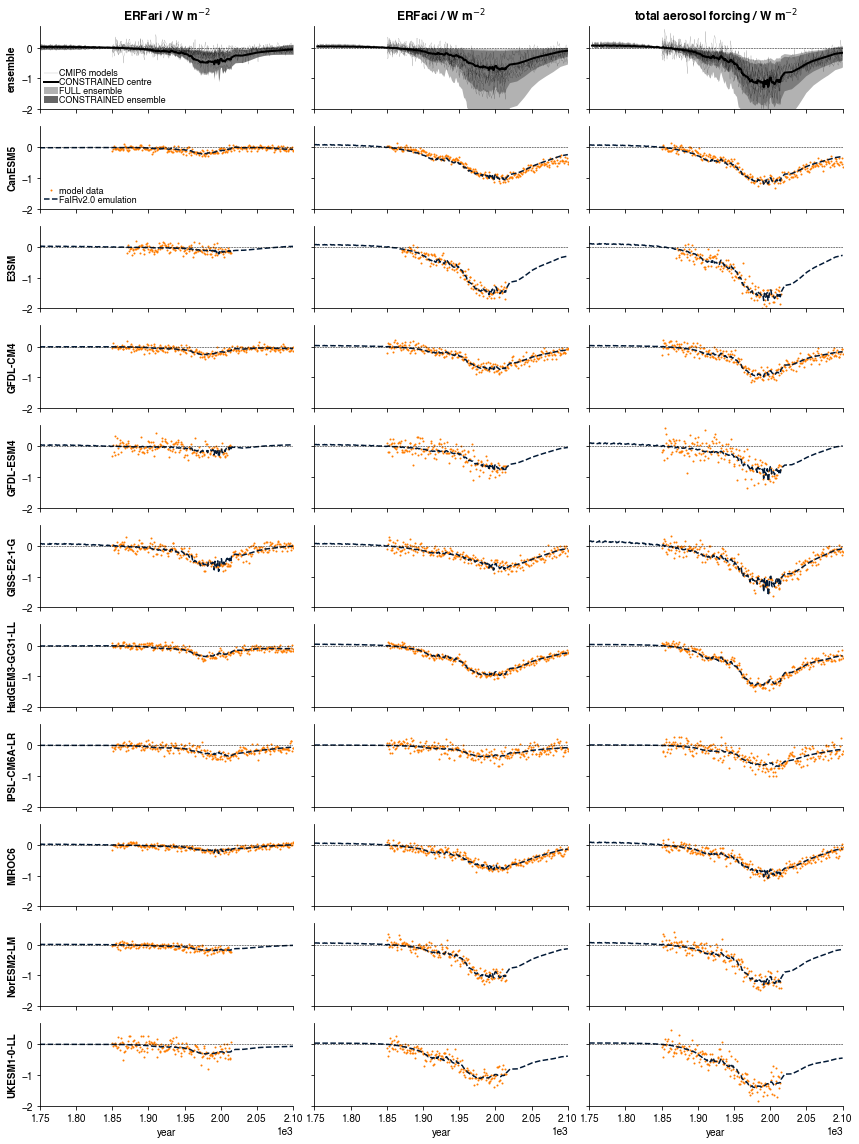

In [145]:
fig,ax = plt.subplots(11,3,figsize=(12,16))

ax[0,0].fill_between(np.arange(1750,2101),*np.quantile(ari_timeseries_FULL,[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax[0,0].fill_between(np.arange(1750,2101),*np.quantile(ari_timeseries_CON,[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax[0,0].plot(np.arange(1750,2101),np.quantile(ari_timeseries_CON,0.5,axis=1),color='k',lw=2)
ax[0,0].plot(CMIP6_aer_forc.loc[:,(slice(None),['aprp_ERFariLW','aprp_ERFariSW'])].replace(np.nan,np.inf).groupby(level=0,axis=1).sum().replace(np.inf,np.nan),color='k',lw=0.1)

ax[0,1].fill_between(np.arange(1750,2101),*np.quantile(aci_timeseries_FULL,[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax[0,1].fill_between(np.arange(1750,2101),*np.quantile(aci_timeseries_CON,[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax[0,1].plot(np.arange(1750,2101),np.quantile(aci_timeseries_CON,0.5,axis=1),color='k',lw=2)
ax[0,1].plot(CMIP6_aer_forc.loc[:,(slice(None),['aprp_ERFaciLW','aprp_ERFaciSW'])].replace(np.nan,np.inf).groupby(level=0,axis=1).sum().replace(np.inf,np.nan),color='k',lw=0.1)

ax[0,2].fill_between(np.arange(1750,2101),*np.quantile(aci_timeseries_FULL+ari_timeseries_FULL,[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax[0,2].fill_between(np.arange(1750,2101),*np.quantile(aci_timeseries_CON+ari_timeseries_CON,[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax[0,2].plot(np.arange(1750,2101),np.quantile(aci_timeseries_CON+ari_timeseries_CON,0.5,axis=1),color='k',lw=2)
ax[0,2].plot(CMIP6_aer_forc.loc[:,(slice(None),['aprp_ERFaciLW','aprp_ERFaciSW','aprp_ERFariLW','aprp_ERFariSW'])].replace(np.nan,np.inf).groupby(level=0,axis=1).sum().replace(np.inf,np.nan),color='k',lw=0.1)

ax[0,0].set_ylabel('ensemble',fontweight='bold')

for i,model in enumerate(ERFari_params.index):

    i+=1
    FaIR_ari_parameterisation = (ERFari_params.loc[model] * RCMIP_aer_emms).sum(axis=1)
    RFMIP_ari_data = CMIP6_aer_forc[model].dropna()[['aprp_ERFariLW','aprp_ERFariSW']].sum(axis=1)
    ax[i,0].plot(RFMIP_ari_data.index,RFMIP_ari_data.values,'o',color=CMIP_color,ms=1)
    ax[i,0].plot(np.arange(1750,2101),FaIR_ari_parameterisation.values,ls='--',color=emulation_color,lw=1.5)
    
    FaIR_aci_parameterisation = (ERFaci_params.loc[model,'beta'] * np.log(1+RCMIP_aer_emms['so2']/ERFaci_params.loc[model,'s']) + ERFaci_params.loc[model,'alpha'] * (RCMIP_aer_emms[['bc','oc']].sum(axis=1)))
    RFMIP_aci_data = CMIP6_aer_forc[model].dropna()[['aprp_ERFaciLW','aprp_ERFaciSW']].sum(axis=1)
    ax[i,1].plot(RFMIP_aci_data.index,RFMIP_aci_data.values,'o',color=CMIP_color,ms=1)
    ax[i,1].plot(np.arange(1750,2101),FaIR_aci_parameterisation.values,ls='--',color=emulation_color,lw=1.5)
    
    ax[i,2].plot(RFMIP_aci_data.index,(RFMIP_aci_data+RFMIP_ari_data).values,'o',color=CMIP_color,ms=1)
    ax[i,2].plot(np.arange(1750,2101),(FaIR_aci_parameterisation+FaIR_ari_parameterisation).values,ls='--',color=emulation_color,lw=1.5)
    
    ax[i,0].set_ylabel(model,fontweight='bold')
    
[a.axhline(0,lw=0.5,ls='--',color='k') for a in ax.flatten()]
    
[a.set_xlim(1750,2100) for a in ax.flatten()]
[a.set_ylim(-2,0.7) for a in ax[:,0]]
[a.set_ylim(-2,0.7) for a in ax[:,1]]
[a.set_ylim(-2,0.7) for a in ax[:,2]]
[ax[0,i].set_title(x,fontweight='bold') for i,x in enumerate(['ERFari / W m$^{-2}$','ERFaci / W m$^{-2}$','total aerosol forcing / W m$^{-2}$'])]
[a.tick_params(labelbottom=False) for a in ax[:-1].flatten()]
[a.tick_params(labelleft=False) for a in ax[:,1:].flatten()]
[a.spines[pos].set_visible(False) for pos in ['top','right'] for a in ax.flatten()]

[a.set_xlabel('year') for a in ax[-1]]

ax[0,0].plot([],[],color='k',lw=0.1,label='CMIP6 models')
ax[0,0].fill_between([],[],color='k',lw=0,alpha=0.3,label='FULL ensemble')
ax[0,0].fill_between([],[],color='k',lw=0,alpha=0.6,label='CONSTRAINED ensemble')
ax[0,0].plot([],[],color='k',lw=2,label='CONSTRAINED centre')

ax[0,0].legend(loc='lower left',prop={'size': 9},labelspacing=0,borderpad=0,handlelength=1.5,handletextpad=0.1)

ax[1,0].plot([],[],'o',color=CMIP_color,ms=1,label='model data')
ax[1,0].plot([],[],ls='--',color=emulation_color,lw=1.5,label='FaIRv2.0 emulation')

ax[1,0].legend(loc='lower left',prop={'size': 9},labelspacing=0,borderpad=0,handlelength=1.5,handletextpad=0.1)

plt.tight_layout()

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/CMIP6_aer_emulation.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

### SSP emulations

In [300]:
## RCMIP SSP emissions:
scenarios = ['ssp'+x for x in ['119','245','585','370']]#['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=scenarios,axis=1).interpolate()
ssp_emms = ssp_emms.loc[1750:2300] - ssp_emms.loc[1750]
ssp_forc = pd.concat([get_RCMIP_forc(x) for x in scenarios],keys=scenarios,axis=1).interpolate().loc[1750:2300]

## switch in GCP co2 emissions up to start of SSPs
GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

for ssp in ssp_emms.columns.levels[0]:
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,(ssp,'carbon_dioxide')]
    ssp_emms.loc[:2014,(ssp,'carbon_dioxide')] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,(ssp,'carbon_dioxide')] *= np.linspace(sf,1,11)

In [301]:
CMIP6_FaIR_run = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=cmip6_gas_params,thermal_parameters=fair_param_df)

Integrating 4 scenarios, 40 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halo

100%|██████████| 550/550 [00:00<00:00, 815.46 timestep/s]


In [302]:
## get the actual historical / ssp data:
ssp_tas = pd.read_csv('../tools/cmip6_data/ssp_tas.csv',index_col=0)
hist_tas = pd.read_csv('../tools/cmip6_data/hist_tas.csv',index_col=0).iloc[1:]

for i,x in enumerate(['source','member','variable','experiment']):
    ssp_tas.loc[x] = [x.split('_')[i+1] for x in ssp_tas.columns]
for i,x in enumerate(['source','member']):    
    hist_tas.loc[x] = [x.split('_')[i+1] for x in hist_tas.columns]
    

ssp_tas=ssp_tas.T.set_index(['source','member','experiment']).T.drop('variable').apply(pd.to_numeric)
hist_tas=hist_tas.T.set_index(['source','member']).T.apply(pd.to_numeric)
ssp_tas['year']=[int(x) for x in ssp_tas.index]
ssp_tas = ssp_tas.set_index('year')
ssp_tas = ssp_tas.reindex(np.arange(1850,2301))

hist_tas['year']=[int(x) for x in hist_tas.index]
hist_tas = hist_tas.set_index('year')

for modmem in hist_tas.columns:
    if modmem in ssp_tas.columns.droplevel(-1):
        for exp in ssp_tas.loc[1850:2014,modmem].columns:
            ssp_tas.loc[1850:2014,(*modmem,exp)] = hist_tas.loc[1850:2014,modmem]

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [303]:
plot_cmip6_tas2100 = ssp_tas.loc[:].groupby(level=(0,2),axis=1).mean()

In [304]:
### plotting the models that have repsonse + aer + cc + RFMIP forc:

chosen_models = ['NorESM2-LM', 'CanESM5', 'IPSL-CM6A-LR']

In [308]:
## add in the RFMIP forcings:

RFMIP_forc = pd.read_csv('../tmp/RFMIP-ERF-tier2.csv',index_col=0)
RFMIP_forc.loc['model'] = [x.split(' ')[0] for x in RFMIP_forc.columns]
RFMIP_forc.loc['erf'] = [x.split(' ')[1] for x in RFMIP_forc.columns]
# RFMIP_forc.T.reset_index()
RFMIP_forc = RFMIP_forc.T.reset_index().set_index(['model','erf']).T.iloc[1:].apply(pd.to_numeric)

EXT_forc = RFMIP_forc.xs('TOT',axis=1,level=-1) - RFMIP_forc.xs('CO2',axis=1,level=-1) - RFMIP_forc.xs('AER',axis=1,level=-1)
EXT_forc = EXT_forc.reindex(chosen_models,axis=1)

EXT_forc = pd.concat([EXT_forc],axis=1,keys=['forcing'])
EXT_forc.columns = EXT_forc.columns.swaplevel(0,1)

FULL_emulation_emms = pd.concat([ssp_emms.loc[:,'ssp245'].reindex(['carbon_dioxide','so2','oc','bc'],axis=1)]*3,axis=1,keys=chosen_models)

In [321]:
FULL_emulation = run_GIR(emissions_in=FULL_emulation_emms.loc[1850:2100],forcing_in=EXT_forc,gas_parameters=cmip6_gas_params.reindex(chosen_models,axis=1,level=0).reindex(['carbon_dioxide','so2','oc','bc','so2|aci','oc|aci','bc|aci'],axis=1,level=-1),thermal_parameters=fair_param_df.reindex(chosen_models,axis=1,level=0))

Integrating 3 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide', 'so2', 'oc', 'bc', 'so2|aci', 'oc|aci', 'bc|aci'] forcing agents, between 1850 and 2100...


100%|██████████| 250/250 [00:00<00:00, 4462.16 timestep/s]


[None, None, None]

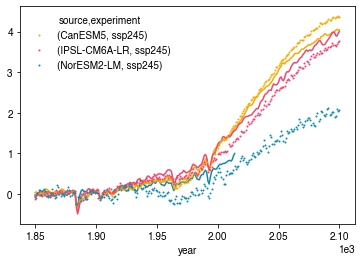

In [346]:
fig,ax = plt.subplots()
colors = ['#118ab2','#F5AB00','#ef476f']
(FULL_emulation['T'] - FULL_emulation['T'].loc[1850:1900].mean()).plot(ax=ax,color=colors,legend=None)
(plot_cmip6_tas2100.loc[:,(chosen_models,'ssp245')]-plot_cmip6_tas2100.loc[1850:1900,(chosen_models,'ssp245')].mean()).plot(ax=ax,marker='o',ms=1,lw=0,color=[colors[1],colors[2],colors[0]])

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/CMIP6_cc_resp_erfaer_FULLemulation_tas.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

[None, None, None]

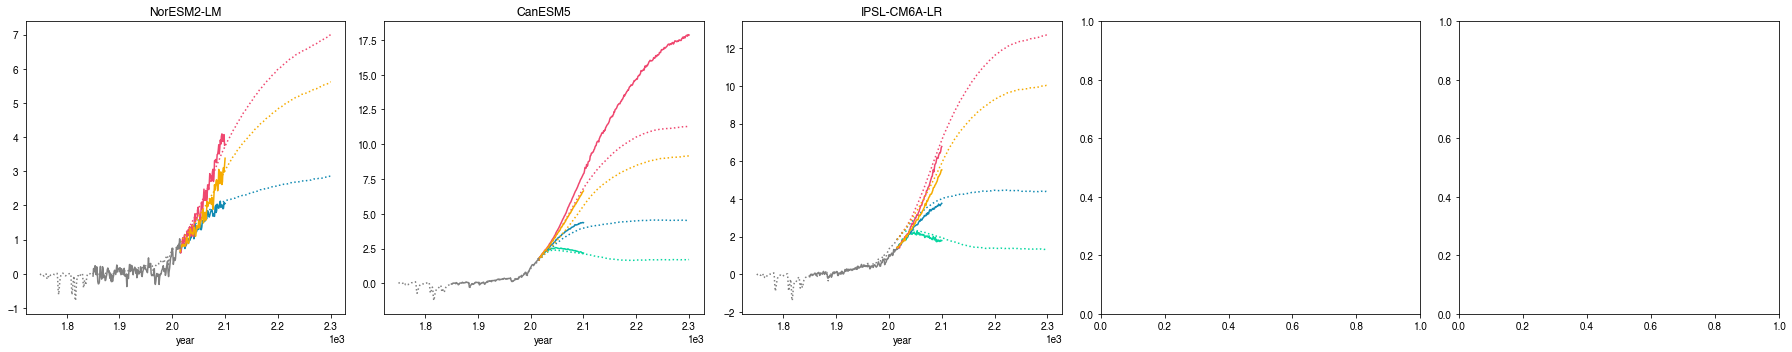

In [347]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

colors= {'ssp245':'#118ab2','ssp370':'#F5AB00','ssp585':'#ef476f','ssp119':'#06d6a0','history':'grey'}

for i,model in enumerate(chosen_models):
    
    plot_data_cmip6 = plot_cmip6_tas2100.loc[:,model]
    for scenario in scenarios:
        if scenario in plot_data_cmip6.columns:
            (plot_data_cmip6.loc[2015:,scenario]-plot_data_cmip6.loc[1850:1900,scenario].mean()).plot(ax=ax[i],color=colors[scenario])
            (CMIP6_FaIR_run['T'].loc[2015:,(scenario,model)]-CMIP6_FaIR_run['T'].loc[1850:1900,(scenario,model)].mean()).plot(ax=ax[i],color=colors[scenario],ls=':')
    (plot_data_cmip6.loc[:2015,'ssp585']-plot_data_cmip6.loc[1850:1900,'ssp585'].mean()).plot(ax=ax[i],color=colors['history'])
    (CMIP6_FaIR_run['T'].loc[:2015,(scenario,model)]-CMIP6_FaIR_run['T'].loc[1850:1900,(scenario,model)].mean()).plot(ax=ax[i],color=colors['history'],ls=':')
    
    ax[i].set_title(model)
    
plt.tight_layout()

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/CMIP6_cc_resp_erfaer_emulation_tas.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

In [348]:
## Import some temperature data
baseline = ['1850','1900']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


[None, None, None]

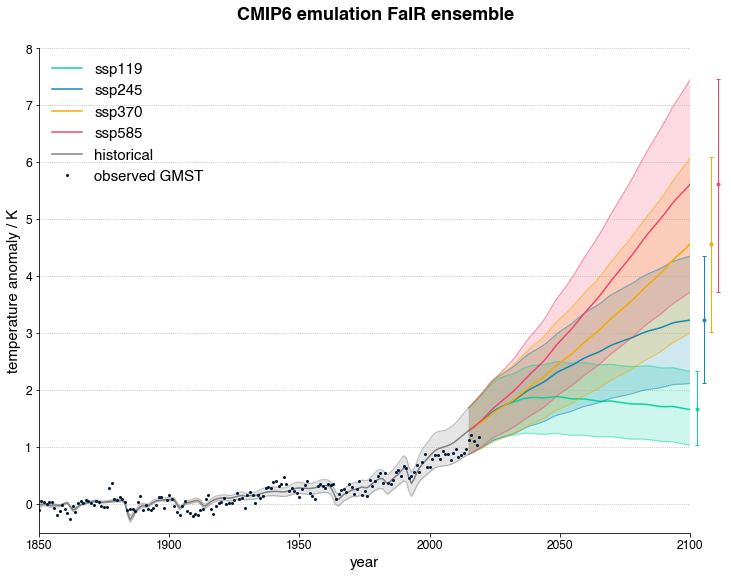

In [349]:
fig = plt.figure(figsize=(10,7.5))
gs = fig.add_gridspec(1, 20,wspace=0)
ax = fig.add_subplot(gs[0,:-1])
colors= {'ssp245':'#118ab2','ssp370':'#F5AB00','ssp585':'#ef476f','ssp119':'#06d6a0','history':'grey'}
for scenario in CMIP6_FaIR_run['T'].columns.levels[0]:
    plot_data = CMIP6_FaIR_run['T'].loc[:,(scenario)] - CMIP6_FaIR_run['T'].loc[1850:1900,(scenario)].mean()
    plot_data.loc[2015:].mean(axis=1).plot(ax=ax,color=colors[scenario],label=scenario)
#     plot_data.loc[2015:].plot(ax=ax,color=colors[scenario],label=scenario,lw=0.1)
    ax.fill_between(plot_data.loc[2015:].index,*np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1),color=colors[scenario],alpha=0.2,lw=0)
    ax.plot(plot_data.loc[2015:].index,np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1).T,color=colors[scenario],alpha=0.5,lw=1.2)
    
plot_data = CMIP6_FaIR_run['T'].loc[:,(scenario)] - CMIP6_FaIR_run['T'].loc[1850:1900,(scenario)].mean()
plot_data.loc[:2015].mean(axis=1).plot(ax=ax,color=colors['history'],label='historical')
ax.fill_between(plot_data.loc[:2015].index,*np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1),color=colors['history'],alpha=0.2,lw=0)
ax.plot(plot_data.loc[:2015].index,np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1).T,color=colors['history'],alpha=0.5,lw=1.2)
    
plt.plot(np.arange(1850,2020),GMST_datasets.loc[:'2019'].mean(axis=1).resample('y').mean().values,'.',ms=4,label='observed GMST')

ax1 = fig.add_subplot(gs[0,-1])
for i,scenario in enumerate(CMIP6_FaIR_run['T'].columns.levels[0]):
    plot_data = CMIP6_FaIR_run['T'].loc[2100,(scenario)] - CMIP6_FaIR_run['T'].loc[1850:1900,(scenario)].mean()
    plot_mean = plot_data.mean()
    plot_lower =  plot_mean - np.quantile(plot_data,0.05)
    plot_upper = np.quantile(plot_data,0.95) - plot_mean
    ax1.errorbar(i,plot_mean,np.array([[plot_lower],[plot_upper]]),color=colors[scenario],capsize=2,fmt='.',lw=1)

ax.yaxis.grid(ls=':')
ax.set_ylim(-0.5,8)
ax1.set_ylim(-0.5,8)
ax1.axis('off')
[ax.spines[pos].set_visible(False) for pos in ['right','top']]
ax.set_xlim(1850,2100)
ax1.set_xlim(-1,4)
ax.legend(loc='upper left',fontsize=15)
plt.tight_layout()
ax.set_ylabel('temperature anomaly / K',fontsize=15)
ax.set_xlabel('year',fontsize=15)
ax.tick_params(labelsize=12)
ax.ticklabel_format(style="plain")

fig.suptitle('CMIP6 emulation FaIR ensemble',fontweight='bold',fontsize=18,y=1.05)

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/CMIP6_ssp_ensemble_emulation.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

In [357]:
## let's try a concentration-driven run...

ssp_concs = pd.concat([RCMIP_to_GIR_input_concs(x) for x in scenarios],keys=scenarios,axis=1).interpolate()

conc_species_list = ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2']

## we now need to add in the aerosol emissions:
for species in ['bc', 'co', 'nh3', 'nmvoc', 'nox', 'nox_avi', 'oc', 'so2']:
    for ssp in ssp_concs.columns.levels[0]:
        emms = ssp_emms.loc[:,(ssp,species)]
        ssp_concs.loc[emms.index,(ssp,species)] = emms.values
        
ssp_concs = ssp_concs.dropna(axis=1,how='all').dropna().reindex(conc_species_list,axis=1,level=1)

In [365]:
CMIP6_FaIR_run_conc_driven = run_GIR(concentrations_in=ssp_concs,forcing_in=ssp_forc,gas_parameters=cmip6_gas_params.reindex([x for x in cmip6_gas_params.columns.levels[-1] if not 'halon1202' in x],axis=1,level=-1),thermal_parameters=fair_param_df,aer_concs_in=['bc', 'co', 'nh3', 'nmvoc', 'nox', 'nox_avi', 'oc', 'so2'])

Integrating 4 scenarios, 40 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o

100%|██████████| 550/550 [00:02<00:00, 233.42 timestep/s]


[None, None, None]

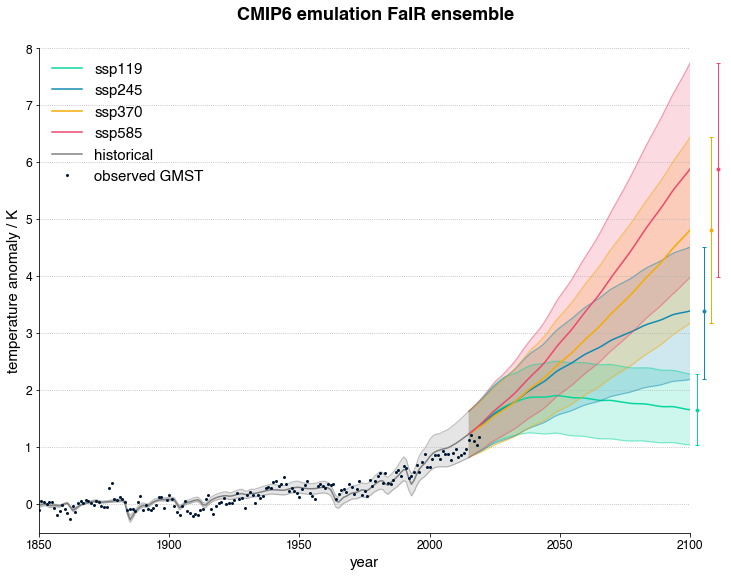

In [366]:
fig = plt.figure(figsize=(10,7.5))
gs = fig.add_gridspec(1, 20,wspace=0)
ax = fig.add_subplot(gs[0,:-1])
colors= {'ssp245':'#118ab2','ssp370':'#F5AB00','ssp585':'#ef476f','ssp119':'#06d6a0','history':'grey'}
for scenario in CMIP6_FaIR_run_conc_driven['T'].columns.levels[0]:
    plot_data = CMIP6_FaIR_run_conc_driven['T'].loc[:,(scenario)] - CMIP6_FaIR_run_conc_driven['T'].loc[1850:1900,(scenario)].mean()
    plot_data.loc[2015:].mean(axis=1).plot(ax=ax,color=colors[scenario],label=scenario)
#     plot_data.loc[2015:].plot(ax=ax,color=colors[scenario],label=scenario,lw=0.1)
    ax.fill_between(plot_data.loc[2015:].index,*np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1),color=colors[scenario],alpha=0.2,lw=0)
    ax.plot(plot_data.loc[2015:].index,np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1).T,color=colors[scenario],alpha=0.5,lw=1.2)
    
plot_data = CMIP6_FaIR_run_conc_driven['T'].loc[:,(scenario)] - CMIP6_FaIR_run_conc_driven['T'].loc[1850:1900,(scenario)].mean()
plot_data.loc[:2015].mean(axis=1).plot(ax=ax,color=colors['history'],label='historical')
ax.fill_between(plot_data.loc[:2015].index,*np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1),color=colors['history'],alpha=0.2,lw=0)
ax.plot(plot_data.loc[:2015].index,np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1).T,color=colors['history'],alpha=0.5,lw=1.2)
    
plt.plot(np.arange(1850,2020),GMST_datasets.loc[:'2019'].mean(axis=1).resample('y').mean().values,'.',ms=4,label='observed GMST')

ax1 = fig.add_subplot(gs[0,-1])
for i,scenario in enumerate(CMIP6_FaIR_run_conc_driven['T'].columns.levels[0]):
    plot_data = CMIP6_FaIR_run_conc_driven['T'].loc[2100,(scenario)] - CMIP6_FaIR_run_conc_driven['T'].loc[1850:1900,(scenario)].mean()
    plot_mean = plot_data.mean()
    plot_lower =  plot_mean - np.quantile(plot_data,0.05)
    plot_upper = np.quantile(plot_data,0.95) - plot_mean
    ax1.errorbar(i,plot_mean,np.array([[plot_lower],[plot_upper]]),color=colors[scenario],capsize=2,fmt='.',lw=1)

ax.yaxis.grid(ls=':')
ax.set_ylim(-0.5,8)
ax1.set_ylim(-0.5,8)
ax1.axis('off')
[ax.spines[pos].set_visible(False) for pos in ['right','top']]
ax.set_xlim(1850,2100)
ax1.set_xlim(-1,4)
ax.legend(loc='upper left',fontsize=15)
plt.tight_layout()
ax.set_ylabel('temperature anomaly / K',fontsize=15)
ax.set_xlabel('year',fontsize=15)
ax.tick_params(labelsize=12)
ax.ticklabel_format(style="plain")

fig.suptitle('CMIP6 emulation FaIR ensemble',fontweight='bold',fontsize=18,y=1.05)

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/CMIP6_ssp_ensemble_emulation_conc_driven.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Probabilistic parameter sampling to match the CMIP6 ranges

### Response parameters

# Emulating ZECMIP experiments
#### get data

In [96]:
onepct_concs = C4MIP_data_1.xs('1pctCO2',axis=1,level=1).loc[:,(slice(None),'CO2')].reindex(['CO2'],axis=1,level=1)
onepct_concs.columns.set_levels(['carbon_dioxide'],level=1,inplace=True)

In [97]:
ZECMIP_cc_params = cmip6_gas_params.reindex(onepct_concs.columns.levels[0],axis=1,level=0).reindex(['carbon_dioxide'],axis=1,level=1)
ZECMIP_response_params = fair_param_df.reindex(onepct_concs.columns.levels[0],axis=1,level=0)

In [98]:
ZECMIP_emms_diagnose = run_GIR(concentrations_in=onepct_concs.dropna(),gas_parameters=ZECMIP_cc_params,thermal_parameters=ZECMIP_response_params)['Emissions']

Integrating 11 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 139...


100%|██████████| 139/139 [00:00<00:00, 6420.30 timestep/s]


In [99]:
## find the exceedence year
ZECMIP_year_exceed = pd.concat([(ZECMIP_emms_diagnose.cumsum()>x).idxmax() for x in [750,1000,2000]],axis=1,keys=[750,1000,2000])

In [100]:
## create the emission series & run for each model:

ZECMIP_model_temps=[]
ZECMIP_model_concs=[]


for model in ZECMIP_emms_diagnose.columns.levels[0]:
    model_emms = pd.DataFrame(index=np.arange(1200),columns=pd.MultiIndex.from_product([[750,1000,2000],['carbon_dioxide']]))
    for emmsum in [750,1000,2000]:
        model_emms.loc[:ZECMIP_year_exceed.loc[(model,'carbon_dioxide'),emmsum],(emmsum,'carbon_dioxide')] = ZECMIP_emms_diagnose.loc[:ZECMIP_year_exceed.loc[(model,'carbon_dioxide'),emmsum],(model,'carbon_dioxide')]
    model_emms.fillna(0,inplace=True)
    model_run = run_GIR(emissions_in=model_emms,gas_parameters=ZECMIP_cc_params.reindex([model],axis=1,level=0),thermal_parameters=ZECMIP_response_params.reindex([model],axis=1,level=0),show_run_info=False)
    ZECMIP_model_temps += [model_run['T'].swaplevel(0,1,axis=1)]
    ZECMIP_model_concs += [model_run['C'].droplevel(2,axis=1).swaplevel(0,1,axis=1)]

100%|██████████| 1199/1199 [00:00<00:00, 3906.38 timestep/s]


In [101]:
ZECMIP_output_temps = pd.concat(ZECMIP_model_temps,axis=1)
ZECMIP_output_concs = pd.concat(ZECMIP_model_concs,axis=1)

In [123]:
## relative to year following cessation

ZECMIP_relative_concs = pd.DataFrame(index=np.arange(1200),columns=pd.MultiIndex.from_product([ZECMIP_output_temps.columns.levels[0],[750,1000,2000]]))
ZECMIP_relative_temps = pd.DataFrame(index=np.arange(1200),columns=pd.MultiIndex.from_product([ZECMIP_output_temps.columns.levels[0],[750,1000,2000]]))

for model in ZECMIP_relative_concs.columns.levels[0]:
    
    for exp in [750,1000,2000]:
        
        cessation_year = ZECMIP_year_exceed.loc[(model,'carbon_dioxide'),exp]
        run_len = 1199 - (cessation_year+1)
        
        ZECMIP_relative_concs.loc[:run_len,(model,exp)] = ZECMIP_output_concs.loc[cessation_year+1:,(model,exp)].values - ZECMIP_output_concs.loc[cessation_year+1,(model,exp)]
        ZECMIP_relative_temps.loc[:run_len,(model,exp)] = ZECMIP_output_temps.loc[cessation_year+1:,(model,exp)].values - ZECMIP_output_temps.loc[cessation_year+1,(model,exp)]

In [167]:
ZECMIP_conc_run = run_GIR(concentrations_in=onepct_concs.dropna(),gas_parameters=ZECMIP_cc_params,thermal_parameters=ZECMIP_response_params)

Integrating 11 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 139...


100%|██████████| 139/139 [00:00<00:00, 6547.34 timestep/s]


In [193]:
TCRE_vals = 1000*ZECMIP_conc_run['T'].loc[69].reset_index().set_index('Scenario')[69]/ZECMIP_conc_run['Emissions'].cumsum().loc[69].droplevel(1)

In [195]:
TCRE_vals

Scenario
ACCESS-ESM1-5    2.015468
BCC-CSM2-MR      1.374284
CESM2            2.060264
CNRM-ESM2-1      1.760733
CanESM5          2.131818
GFDL-ESM4        1.368797
IPSL-CM6A-LR     2.048248
MIROC-ES2L       1.420012
MPI-ESM1-2-LR    1.537576
NorESM2-LM       1.350411
UKESM1-0-LL      2.564836
Name: 69, dtype: float64